In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
print("Missing Values 'Review Text':", df['Review Text'].isnull().sum())
print("Missing Values 'Rating':", df['Rating'].isnull().sum())
print("Missing Values'Recommended IND':", df['Recommended IND'].isnull().sum())

Missing Values 'Review Text': 845
Missing Values 'Rating': 0
Missing Values'Recommended IND': 0


In [4]:
df = df.dropna(subset=['Review Text', 'Rating', 'Recommended IND'])

In [5]:
nlp = spacy.load('en_core_web_sm')

def process_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

print("Tokenization...")
df['processed_text'] = df['Review Text'].apply(process_text)
print("Tokenization fin.")

Tokenization...
Tokenization fin.


In [6]:
vectorizer = CountVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['processed_text'])
feature_names = vectorizer.get_feature_names_out()
X_text_df = pd.DataFrame(X_text.toarray(), columns=feature_names)

In [7]:
X_train, X_test, y_train_rating, y_test_rating, y_train_rec, y_test_rec = train_test_split(
    X_text_df, df['Rating'], df['Recommended IND'], test_size=0.2, random_state=42
)


In [8]:
rating_model = RandomForestRegressor(n_estimators=100, random_state=42)
rating_model.fit(X_train, y_train_rating)

rec_model = RandomForestClassifier(n_estimators=100, random_state=42)
rec_model.fit(X_train, y_train_rec)

RandomForestClassifier(random_state=42)

In [9]:
rating_preds = rating_model.predict(X_test)
rating_preds_rounded = np.round(rating_preds).clip(1, 5)
mse = mean_squared_error(y_test_rating, rating_preds)
exact_accuracy = accuracy_score(y_test_rating, rating_preds_rounded)
print("\nRésultats de la prédiction de notation :")
print(f"MSE: {mse:.4f}")
print(f"ТAccurancy: {exact_accuracy:.4f}")



Résultats de la prédiction de notation :
MSE: 0.7705
ТAccurancy: 0.5348


In [10]:
rec_preds = rec_model.predict(X_test)
rec_accuracy = accuracy_score(y_test_rec, rec_preds)
print("\nRésultats de prédiction de recommandation:")
print(f"Accurancy: {rec_accuracy:.4f}")
print(classification_report(y_test_rec, rec_preds))


Résultats de prédiction de recommandation:
Accurancy: 0.8607
              precision    recall  f1-score   support

           0       0.82      0.28      0.42       812
           1       0.86      0.99      0.92      3717

    accuracy                           0.86      4529
   macro avg       0.84      0.64      0.67      4529
weighted avg       0.86      0.86      0.83      4529



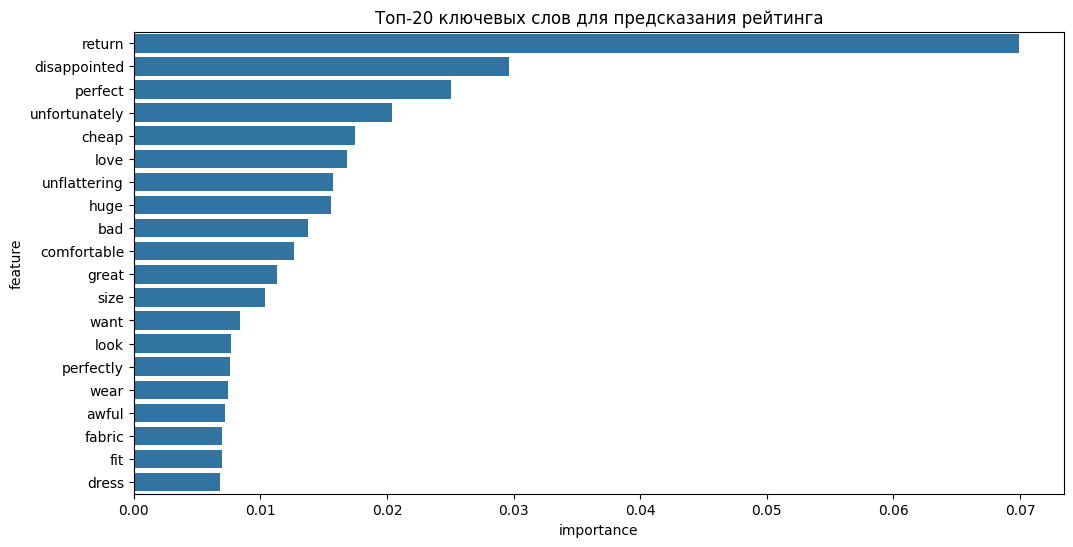

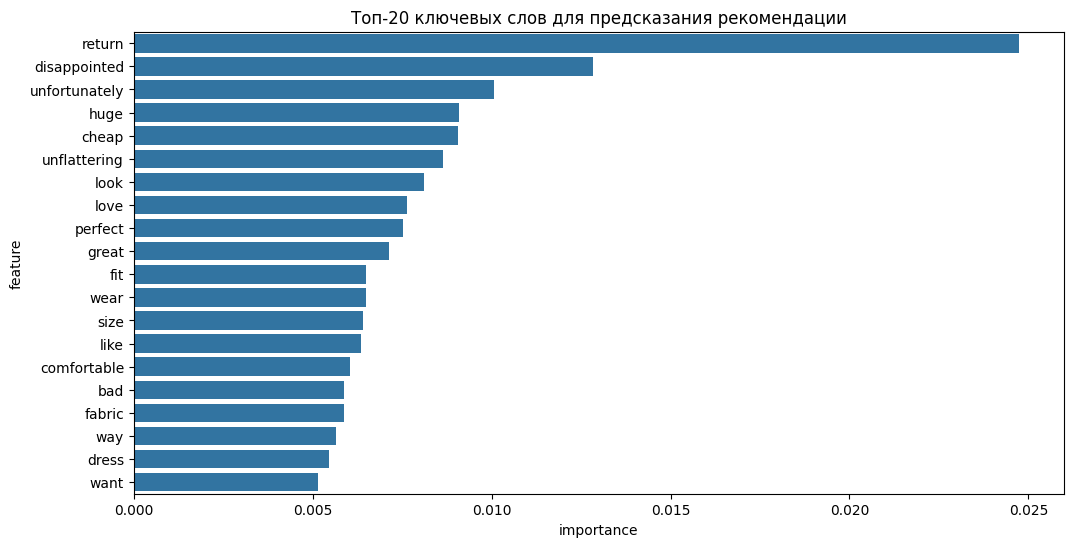

In [11]:
rating_importance = pd.DataFrame({'feature': feature_names, 'importance': rating_model.feature_importances_})
rating_importance = rating_importance.sort_values('importance', ascending=False).head(20)

rec_importance = pd.DataFrame({'feature': feature_names, 'importance': rec_model.feature_importances_})
rec_importance = rec_importance.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=rating_importance)
plt.title('Топ-20 ключевых слов для предсказания рейтинга')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=rec_importance)
plt.title('Топ-20 ключевых слов для предсказания рекомендации')
plt.show()

In [12]:
def predict_from_review(review_text):
    processed = process_text(review_text)
    vector = vectorizer.transform([processed])
    rating = rating_model.predict(vector)[0]
    recommended = rec_model.predict(vector)[0]
    return {
        'predicted_rating': round(rating, 1),
        'predicted_recommendation': 'Recommended' if recommended == 1 else 'Not Recommended'
    }

# Пример предсказания
example_review = "This dress is amazing! The fit is perfect and the material is high quality."
predictions = predict_from_review(example_review)
print("\nPrévision pour un exemple d'examen:")
print(f"Review: {example_review}")
print(f"Rating prévue: {predictions['predicted_rating']}")
print(f"Recommandation prévue: {predictions['predicted_recommendation']}")


Prévision pour un exemple d'examen:
Review: This dress is amazing! The fit is perfect and the material is high quality.
Rating prévue: 5.0
Recommandation prévue: Recommended


c:\Users\mynam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\mynam\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [13]:
import os
import joblib

os.makedirs("models", exist_ok=True)
joblib.dump(rating_model, "models/rating_model.pkl")
joblib.dump(rec_model, "models/recommendation_model.pkl")
joblib.dump(vectorizer, "models/vectorizer.pkl")
print("Les modèles et le vectoriseur sont enregistrés dans le dossier models/")

Les modèles et le vectoriseur sont enregistrés dans le dossier models/


In [14]:
from sklearn.model_selection import GridSearchCV


param_grid_rating = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],     
    'min_samples_split': [2, 5, 10] 
}

grid_search_rating = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rating, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rating.fit(X_train, y_train_rating)

best_rating_model = grid_search_rating.best_estimator_

print("Meilleurs paramètres pour l'évaluation:", grid_search_rating.best_params_)


KeyboardInterrupt: 

In [ ]:
param_grid_rec = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [10, 20, None],     
    'min_samples_split': [2, 5, 10]
}

grid_search_rec = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rec, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rec.fit(X_train, y_train_rec)

best_rec_model = grid_search_rec.best_estimator_

print("Лучшие параметры для рекомендации:", grid_search_rec.best_params_)


ValueError: Found input variables with inconsistent numbers of samples: [22862, 19662]

In [16]:
rating_preds = best_rating_model.predict(X_test)
rating_preds_rounded = np.round(rating_preds).clip(1, 5)
mse = mean_squared_error(y_test_rating, rating_preds)
accuracy = accuracy_score(y_test_rating, rating_preds_rounded)

print("\nÉvaluation du modèle de notation amélioré:")
print(f"(MSE): {mse:.4f}")
print(f"Précision de la correspondance exacte: {accuracy:.4f}")

rec_preds = best_rec_model.predict(X_test)
rec_accuracy = accuracy_score(y_test_rec, rec_preds)

print("\nÉvaluation du modèle de recommandation amélioré:")
print(f"Accarancy: {rec_accuracy:.4f}")
print(classification_report(y_test_rec, rec_preds))


NameError: name 'best_rating_model' is not defined